# Publication Figure 3

This jupyter notebook contains the Analysis code for an upcoming publication.

Authors: Kevin Sawade (kevin.sawade@uni-konstanz.de), Christine Peter (christine.peter@uni-konstanz.de)

EncoderMap's featurization was inspired by the (no longer maintained) PyEMMA library. Consider citing it (https://dx.doi.org/10.1021/acs.jctc.5b00743), if you are using EncoderMap:

## Imports

We start with the imports.

In [1]:
# Future imports at the top
from __future__ import annotations

# Import EncoderMap
import encodermap as em
from encodermap.plot import plotting
from encodermap.plot.plotting import _plot_free_energy

# Builtin packages
import re
import io
import warnings
import os
import json
import contextlib
import time
from copy import deepcopy
from types import SimpleNamespace
from pathlib import Path

# Math
import numpy as np
import pandas as pd
import xarray as xr

# ML
import tensorflow as tf

# Plotting
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.io as pio

# MD
import mdtraj as md
import MDAnalysis as mda
import nglview as nv

# dates
from dateutil import parser

/home/kevin/git/encoder_map_private/encodermap/__init__.py:194: GPUsAreDisabledWarning: EncoderMap disables the GPU per default because most tensorflow code runs with a higher compatibility when the GPU is disabled. If you want to enable GPUs manually, set the environment variable 'ENCODERMAP_ENABLE_GPU' to 'True' before importing EncoderMap. To do this in python you can run:

import os; os.environ['ENCODERMAP_ENABLE_GPU'] = 'True'

before importing encodermap.
  _warnings.warn(


Using Autoreload we can make changes in the EncoderMap source code and use the new code, without needing to restart the Kernel.

In [2]:
%load_ext autoreload
%autoreload 2

## Trained network weights

EncoderMap's Neural Network is initialized with random weights and biases. While the training is deterministic with pre-defined training weights, and the inferences that can be made from two trained models are qualitatively similar, the numerical exact output depends on the starting weights.

For this reason, the trained network weights are available from the corresponding authors upon reasonable request or by raising an issue on GitHub: https://github.com/AG-Peter/encodermap/issues

This figure demonstrates the

1) The modularity of the EncoderMap package.
2) Some interactive elements in EncoderMap.

### Get data

We will use the same data as in Figure 1. To obtain the `H1Ub_trajs` variable, use the cells from figure 1. We will also use the `SASA_dists` collective variable as the training input. For plotting, we will select a subset of the trajectory ensemble with 10000 frames.

In [3]:
figure_1_data_dir = Path.cwd() / "analysis/figure_1"
if not figure_1_data_dir.exists():
    figure_1_data_dir.mkdir(parents=True)
em.get_from_kondata(
    "H1Ub",
    figure_1_data_dir,
    silence_overwrite_message=True,
    mk_parentdir=True,
)
H1Ub_trajs_file = figure_1_data_dir / "trajs.h5"
H1Ub_trajs = em.load(H1Ub_trajs_file)

### Train Networks

We need to train three networks.

#### Network 1: Autoencoder

This network does not implement any cost function, that links the input and the latent space. This can easily be achieved in EncoderMap by setting the `distance_cost_scale` parameter to 0:

In [4]:
figure_3_trained_nn_dir = Path.cwd() / "trained_networks/figure_3"

In [5]:
if input(
    f"Re-train the autoencoder network (y) or load from provided data (N)?"
) == "y":
    # train
    p = em.Parameters(
        tensorboard=True,
        main_path=em.misc.run_path(Path.cwd() / "analysis/autoencoder"),
        n_steps=3_000,
        summary_step=10,
        distance_cost_scale=0,
    )
    autoencoder = em.EncoderMap(
        parameters=p,
        train_data=ds,
    )
    autoencoder.add_images_to_tensorboard(data=plotting_data)
    history = autoencoder.train()
    json.dump(history.history, open(Path(autoencoder.p.main_path) / "history.json", 'w'))
else:
    # load
    autoencoder = em.EncoderMap.from_checkpoint(figure_3_trained_nn_dir / "autoencoder")

Re-train the autoencoder network (y) or load from provided data (N)? 


Seems like the parameter file was moved to another directory. Parameter file is updated ...
Output files are saved to /home/kevin/git/encoder_map_private/docs/source/notebooks/publication/trained_networks/figure_3/autoencoder as defined in 'main_path' in the parameters.
Saved a text-summary of the model and an image in /home/kevin/git/encoder_map_private/docs/source/notebooks/publication/trained_networks/figure_3/autoencoder, as specified in 'main_path' in the parameters.


#### Extract a cluster from the projection using `autoencoder`

This cluster will then be used in the preparation of figure 3.

In [ ]:
H1Ub_trajs.del_CVs(["_user_selected_points", "lowd"])
sess = em.InteractivePlotting(
    trajs=H1Ub_trajs,
    highd_data=H1Ub_trajs.CVs["SASA_dists"],
    autoencoder=autoencoder,
)

In [ ]:
# cluster = em.load(figure_3_trained_nn_dir / "autoencoder/clusters/cluster0/cluster_0.h5")
# traj = cluster.stack()
# traj.save_pdb(figure_3_trained_nn_dir / "autoencoder/clusters/cluster0/cluster_0.pdb")

#### Network 2: A MDS-like cost function

This cost function needs to be implemented, as it is not present in EncoderMap. Luckily, EncoderMap allows us to do this, by adhering to some design rules.

In [6]:
# We will import the function pairwise_dist()
# and pairwise_dist_periodic() 
# from EncoderMap's misc sub-package.
from encodermap.misc.distances import pairwise_dist, pairwise_dist_periodic


def MDS_loss(model, parameters):
    """Outer function of our MDS loss.

    Similar to the other loss closures in
    EncoderMap, the outer function takes
    two arguments: model and parameters.

    We can also implement additinal logic
    to print in the outer function.

    Args:
        model (tf.keras.Model): A tensorflow model.
            This model is required to have an attribute
            called `encoder`, which will be used
            to get the output of the bottleneck neurons.
        parameters (em.parameters.AnyParameters): An
            instance of EncoderMap's parameter classes.

    Returns:
        Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
            The inner function, which tensorflow uses
            to calculate the MDS loss.
    
    """
    # to get intermediate output for loss calculations
    latent = model.encoder
    periodicity = parameters.periodicity

    print("Outer function of MDS loss called.")

    def MDS_loss_fn(y_true, y_pred=None):
        """Inner MDS loss function.

        The inner function must return a scalar value.

        Args:
            y_true (tf.Tensor): The input.
            y_pred (tf.Tensor): The output. This
                argument will not be used. We are not
                interested in the output of the decoder.

        Returns:
            tf.Tensor: The output scalar tensor.
        
        """
        # lowd and highd are defines like so
        lowd = latent(y_true)
        highd = y_true

        # pairwise distances are calculated like so
        # for the input, we have to respect the 
        # periodicity of the input space.
        pairwise_lowd = pairwise_dist(lowd)
        pairwise_highd = pairwise_dist_periodic(
            positions=highd,
            periodicity=periodicity,
        )

        # The mean squared differences of the
        # pairwise distances is the MDS cost
        cost = tf.reduce_mean(
            tf.square(
                pairwise_highd - pairwise_lowd
            )
        )

        # log to tensorboard
        tf.summary.scalar('MDS Cost', cost)
        return cost
    return MDS_loss_fn

In [7]:
if input(
    f"Re-train the MDS-autoencoder network (y) or load from provided data (N)?"
) == "y":
    # train
    p = em.Parameters(
        tensorboard=True,
        main_path=em.misc.run_path(Path.cwd() / "analysis/custom_mds"),
        n_steps=3_000,
        summary_step=10,
        distance_cost_scale=0,
    )
    custom_mds = em.EncoderMap(
        parameters=p,
        train_data=ds,
    )
    custom_mds.add_loss(MDS_loss)
    custom_mds.add_images_to_tensorboard(data=plotting_data)
    history = custom_mds.train()
    json.dump(history.history, open(Path(custom_mds.p.main_path) / "history.json", 'w'))
else:
    # load
    autoencoder_with_mds = em.EncoderMap.from_checkpoint(figure_3_trained_nn_dir / "mds")

Re-train the MDS-autoencoder network (y) or load from provided data (N)? 


Seems like the parameter file was moved to another directory. Parameter file is updated ...
Output files are saved to /home/kevin/git/encoder_map_private/docs/source/notebooks/publication/trained_networks/figure_3/mds as defined in 'main_path' in the parameters.
Saved a text-summary of the model and an image in /home/kevin/git/encoder_map_private/docs/source/notebooks/publication/trained_networks/figure_3/mds, as specified in 'main_path' in the parameters.


#### Extract a cluster from the projection using `autoencoder_with_mds`

This cluster will then be used in the preparation of figure 3.

In [ ]:
H1Ub_trajs.del_CVs(["_user_selected_points", "lowd"])
sess = em.InteractivePlotting(
    trajs=H1Ub_trajs,
    highd_data=H1Ub_trajs.CVs["SASA_dists"],
    autoencoder=autoencoder_with_mds,
)

In [ ]:
# cluster = em.load(figure_3_trained_nn_dir / "mds/clusters/cluster0/cluster_0.h5")
# traj = cluster.stack()
# traj.save_pdb(figure_3_trained_nn_dir / "mds/clusters/cluster0/cluster_0.pdb")

#### Network 3: Full EncoderMap with sketch-map cost

Now, we turn on the regular distance cost in EncoderMap by setting `distance_cost_scale` to 1 and providing the sigmoid parameters defined in https://doi.org/10.1371/journal.pcbi.1010531 (`dist_sig_parameters=(6, 10, 3, 6, 2, 3)`). We will also set the periodicity to `periodicity=float("inf")` to tell EncoderMap, that the SASA distances don't lie in a periodic space.

In [8]:
if input(
    f"Re-train the encodermap network (y) or load from provided data (N)?"
) == "y":
    # train
    p = em.Parameters(
        tensorboard=True,
        main_path=em.misc.run_path(Path.cwd() / "analysis/encodermap"),
        n_steps=3_000,
        summary_step=10,
        dist_sig_parameters=(6, 10, 3, 6, 2, 3),
        distance_cost_scale=1,
        periodicity=float("inf")
    )
    encodermap = em.EncoderMap(
        parameters=p,
        train_data=ds,
    )
    encodermap.add_images_to_tensorboard(data=plotting_data)
    history = encodermap.train()
    json.dump(history.history, open(Path(encodermap.p.main_path) / "history.json", 'w'))
else:
    # load
    emap = em.EncoderMap.from_checkpoint(figure_3_trained_nn_dir / "encodermap")

Re-train the encodermap network (y) or load from provided data (N)? 


Seems like the parameter file was moved to another directory. Parameter file is updated ...
Output files are saved to /home/kevin/git/encoder_map_private/docs/source/notebooks/publication/trained_networks/figure_3/encodermap as defined in 'main_path' in the parameters.
Saved a text-summary of the model and an image in /home/kevin/git/encoder_map_private/docs/source/notebooks/publication/trained_networks/figure_3/encodermap, as specified in 'main_path' in the parameters.


#### Extract a cluster from the trained EncoderMap projection

In [ ]:
H1Ub_trajs.del_CVs(["_user_selected_points", "lowd"])
sess = em.InteractivePlotting(
    trajs=H1Ub_trajs,
    highd_data=H1Ub_trajs.CVs["SASA_dists"],
    autoencoder=emap,
)

In [ ]:
# cluster = em.load(figure_3_trained_nn_dir / "encodermap/clusters/cluster0/cluster_0.h5")
# traj = cluster.stack()
# traj.save_pdb(figure_3_trained_nn_dir / "encodermap/clusters/cluster0/cluster_0.pdb")

### Final image

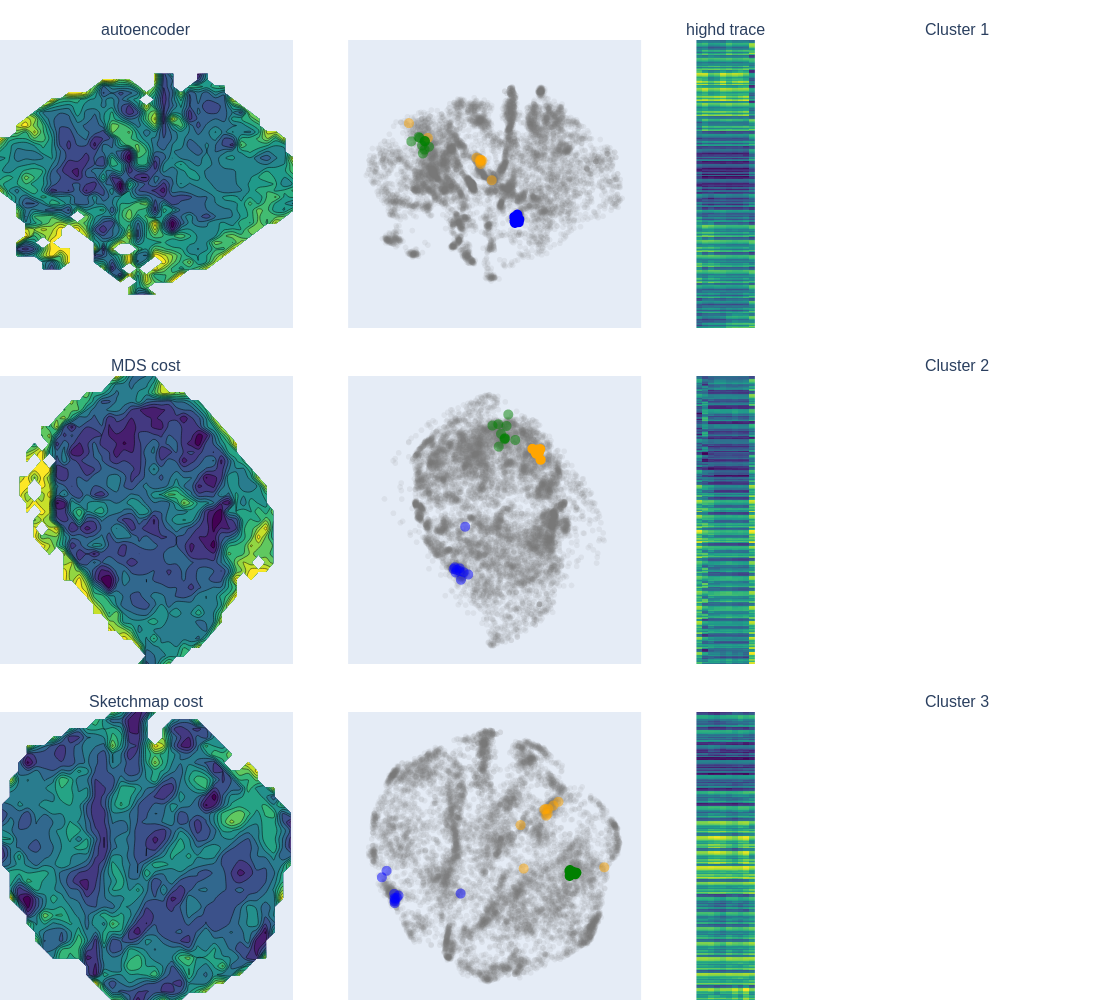

In [9]:
from encodermap.plot.plotting import _plot_free_energy
from PIL import Image

fig = make_subplots(
    cols=4,
    rows=3,
    subplot_titles=[
        "autoencoder", "", "highd trace", "Cluster 1",
        "MDS cost", "", "", "Cluster 2",
        "Sketchmap cost", "", "", "Cluster 3",
    ],
    column_widths=[1, 1, 0.2, 1],
    horizontal_spacing=0.05,
    vertical_spacing=0.05,
)

for i, (datasource, autoencoder_class) in enumerate(
    zip(
        ["autoencoder", "mds", "encodermap"],
        [autoencoder, autoencoder_with_mds, emap],
    )
):
    highd_data = H1Ub_trajs.SASA_dists
    lowd_data = autoencoder_class.encode(highd_data)
    fig.add_trace(
        _plot_free_energy(
            x=lowd_data[:, 0],
            y=lowd_data[:, 1],
            bins=35
        ),
        row=1+i,
        col=1,
    )

    fig.add_trace(
        go.Scattergl(
            x=lowd_data[::5, 0],
            y=lowd_data[::5, 1],
            marker_color="rgba(120, 120, 120, 0.1)",
            mode="markers",
            name="",
            showlegend=False,
        ),
        row=i+1,
        col=2,
    )

    for j, (cluster_source, cluster_color) in enumerate(
        zip(
            ["autoencoder", "mds", "encodermap"],
            ["blue", "orange", "green"],
        )
    ):
        cluster_traj = em.load(figure_3_trained_nn_dir / f"{cluster_source}/clusters/cluster0/cluster_0.h5")
        cluster_highd = cluster_traj.SASA_dists
        cluster_lowd = autoencoder_class.encode(cluster_highd)

        fig.add_trace(
            go.Scattergl(
                x=cluster_lowd[:, 0],
                y=cluster_lowd[:, 1],
                marker_color=cluster_color,
                marker_opacity=1.0 if j == i else 0.5,
                marker_size=10,
                mode="markers",
                name="",
                showlegend=False,
            ),
            row=i+1,
            col=2,
        )

        # highd trace
        if i == j:
            fig.add_trace(
                go.Heatmap(
                    z=cluster_highd.T,
                    showlegend=False,
                    showscale=False,
                    colorscale="Viridis",
                    hoverinfo="skip",
                    name="",
                    hovertemplate="",
                ),
                row=i+1,
                col=3,
            )

    # image
    # image_file = figure_3_trained_nn_dir / f"{datasource}/clusters/cluster0/cluster_0_chimeraX_render.png"
    # with Image.open(image_file) as img:
    #     fig.add_trace(
    #         go.Image(z=np.asarray(img)),
    #         row=i+1,
    #         col=4,
    #     )
    
showstuff = False
fig.for_each_xaxis(lambda x: x.update(showgrid=showstuff, showline=showstuff, zeroline=showstuff, showticklabels=showstuff))
fig.for_each_yaxis(lambda x: x.update(showgrid=showstuff, showline=showstuff, zeroline=showstuff, showticklabels=showstuff))
scales = {}
identifier = 1
for row in range(1, 4):
    for col in range(1, 5):
        if col in [1, 2] and row in [1, 2, 3]:
            scales[f"yaxis{identifier}"] = {
                "scaleanchor": f"x{identifier}",
                "scaleratio": 1,
            }
        identifier += 1
fig.update_layout(
    {
        "width": 1000,
        "height": 1000,
        "margin": dict(t=40, b=0, r=0, l=0),
    } | scales,
)
# fig.write_image(figure_3_trained_nn_dir / "figure3.svg", scale=2)
# fig.write_image(figure_3_trained_nn_dir / "figure3.png", scale=2)
fig.show()